In [0]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import random
import re
import string
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Embedding, LSTM, BatchNormalization, Dense, Activation, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.backend import clear_session
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import gensim
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
analyzer = SentimentIntensityAnalyzer()

In [0]:
def get_review_ratings(string):
    """takes the required numbers from the review ratings column"""
    return int(re.findall(takenums, string)[0]) / 10

In [0]:
def remove_chevron_contents(string):
    """removes unwanted html tags from reviews"""
    return re.sub(remchev,'', string)

In [0]:
def remove_whitespace(string):
    """removes unwanted whitespace from start and end of restaurant names"""
    return re.sub(remspace, '', string)

In [0]:
def get_restaurant_ratings(string):
    """extracts restaurant ratings from strings"""
    return float(re.findall(first3chars, string)[0])

In [0]:
def remove_non_nums(string):
    """extracts numeric characters from a string"""
    return int(re.sub(numsonly, '', string))

In [0]:
def get_vader_scores(review):
    scores = []
    for sentence in review:
        scores.append(analyzer.polarity_scores(sentence)['compound'])
    return scores

In [0]:
def preprocessing(review):
    """split each review into words, taking into account the way nltk handles punctuation"""
    # replace full stops by a space (as nltk tokenizer does not separate words with a full stop and no space)
    nodots = re.sub('\.', ' ', review)
    # split review into list of word 'tokens'
    tokens = word_tokenize(nodots)
    # convert to lower case 
    lowercase = [token.lower() for token in tokens]
    # remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in lowercase]
    # filter out remaining non-alphabetic tokens
    words = [word for word in stripped if word.isalpha()]
    # finally, remove stop words
    tokens = [w for w in words if not w in stop_words]
    return tokens

In [0]:
df = pd.read_csv('/content/gdrive/My Drive/output_ANOTHER.csv')

In [0]:
df.describe()

,reviewer_name,review_rating,review_title,full_reviews,review_date,restaurant_name,restaurant_rating,restaurant_review_count
count,394692,394692,394691,394692,394692,394692,394692,394692
unique,163209,6,246734,388073,110,2204,10,630
top,david n,"<span class=""ui_bubble_rating bubble_50""></span>",Excellent,"<p class=""partial_entry"">We have been to this ...",August 2016,Jamie's Italian,4.0 of 5 bubbles,"5,243 Reviews"
freq,280,220694,2150,4,7692,4751,164729,4751


In [0]:
df.drop_duplicates(inplace=True)

In [0]:
# select and delete an erroneous row that appears in the scraped csv file, whose values are equal to the column names
delete = df.index[df['restaurant_rating'] == 'restaurant_rating'][0]

In [0]:
df.drop(delete, inplace=True)

In [0]:
# regular expressions to clean the text:
takenums = '\d+'
remchev = '\<(.*?)\>'
remspace = '^[ \t]+|[ \t]+$'
first3chars = '^...'
numsonly = '[^0-9]'

In [0]:
df['review_rating'] = df['review_rating'].apply(get_review_ratings)

In [0]:
df['full_reviews'] = df['full_reviews'].apply(remove_chevron_contents)

In [0]:
df['restaurant_name'] = df['restaurant_name'].apply(remove_whitespace)

In [0]:
df['restaurant_rating'] = df['restaurant_rating'].apply(get_restaurant_ratings)

In [0]:
df['restaurant_review_count'] = df['restaurant_review_count'].apply(remove_non_nums)

In [0]:
df.head(10)

,reviewer_name,review_rating,review_title,full_reviews,review_date,restaurant_name,restaurant_rating,restaurant_review_count
0,allanKeswick,5.0,loved the staff,I was in Manchester with my tg gurlfriend and ...,March 2019,No. 1 Canal Street,4.5,286
1,396sidh,4.0,Quick & Good lunch !,It was our anniversary and we were looking for...,March 2019,No. 1 Canal Street,4.5,286
2,458stepheno,5.0,Really enjoy,Hey a lovely meal staff where lovely was over ...,March 2019,No. 1 Canal Street,4.5,286
3,mancgay44,4.0,"Service Excellent, food beautiful","Everything was lovely, especially peanut butte...",March 2019,No. 1 Canal Street,4.5,286
4,125dalem,5.0,"Amazing food, Amazing service every time",Every time we visit No.1 Canal Street we get t...,March 2019,No. 1 Canal Street,4.5,286
5,Stacey W,5.0,Amazing restaurant,Visited here for anniversary. The food was abs...,March 2019,Alston Bar & Beef,4.5,618
6,pbarrett1116,5.0,Fantastic steak. Great price,Wow. 2 courses for 15 pounds. Usually means ba...,March 2019,Alston Bar & Beef,4.5,618
7,crowlady1922,5.0,"Excellent steak, and even better service!","I visited this restaurant last Saturday, and w...",March 2019,Alston Bar & Beef,4.5,618
8,graybird,4.0,mixed feelings.,"Cannot fault the food or service, cleanliness ...",March 2019,Alston Bar & Beef,4.5,618
9,Getaway54377574843,5.0,The best steak in town!,The staff couldn’t do enough for us and the fo...,March 2019,Alston Bar & Beef,4.5,618


In [0]:
df['title_plus_review'] = df['review_title'].astype(str) + ". " + df['full_reviews'].astype(str)

In [0]:
df['sentences'] = df['title_plus_review'].apply(sent_tokenize)

In [0]:
df['vader_scores'] = df['sentences'].apply(get_vader_scores)

In [0]:
df['avg_vader_score'] = df['vader_scores'].apply(np.mean)

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
stop_words = set(stopwords.words('english'))

In [0]:
# list of "stop words" I wanted to keep as they carry semantic importance
stop_words.remove("not")
stop_words.remove("but")
stop_words.remove("only")
stop_words.remove("against")
stop_words.remove("again")
stop_words.remove("nor")
stop_words.remove("no")
stop_words.remove("off")

In [0]:
df['words'] = df['full_reviews'].apply(preprocessing)

In [0]:
df.head()

,reviewer_name,review_rating,review_title,full_reviews,review_date,restaurant_name,restaurant_rating,restaurant_review_count,title_plus_review,sentences,vader_scores,avg_vader_score,words
0,allanKeswick,5.0,loved the staff,I was in Manchester with my tg gurlfriend and ...,March 2019,No. 1 Canal Street,4.5,286,loved the staff. I was in Manchester with my t...,"[loved the staff., I was in Manchester with my...","[0.5994, 0.8078, 0.7713, 0.2846, 0.2732, 0.9022]",0.606417,"[manchester, tg, gurlfriend, restaurant, recom..."
1,396sidh,4.0,Quick & Good lunch !,It was our anniversary and we were looking for...,March 2019,No. 1 Canal Street,4.5,286,Quick & Good lunch !. It was our anniversary a...,"[Quick & Good lunch !., It was our anniversary...","[0.4926, 0.0, 0.7506, 0.9652, 0.5719, 0.6361]",0.569400,"[anniversary, looking, reasonably, priced, lun..."
2,458stepheno,5.0,Really enjoy,Hey a lovely meal staff where lovely was over ...,March 2019,No. 1 Canal Street,4.5,286,Really enjoy . Hey a lovely meal staff where l...,"[Really enjoy ., Hey a lovely meal staff where...","[0.5413, 0.8225, 0.4767]",0.613500,"[hey, lovely, meal, staff, lovely, times, chec..."
3,mancgay44,4.0,"Service Excellent, food beautiful","Everything was lovely, especially peanut butte...",March 2019,No. 1 Canal Street,4.5,286,"Service Excellent, food beautiful. Everything ...","[Service Excellent, food beautiful., Everythin...","[0.8225, 0.7232]",0.772850,"[everything, lovely, especially, peanut, butte..."
4,125dalem,5.0,"Amazing food, Amazing service every time",Every time we visit No.1 Canal Street we get t...,March 2019,No. 1 Canal Street,4.5,286,"Amazing food, Amazing service every time . Eve...","[Amazing food, Amazing service every time ., E...","[0.8225, 0.6696, 0.6239, 0.7311, 0.0]",0.569420,"[every, time, visit, no, canal, street, get, b..."


In [0]:
df['word_count'] = df['words'].apply(len)

In [0]:
wv = gensim.models.word2vec.Word2Vec(df['words'], size=15, window=5, min_count=1)

In [0]:
vocabulary = list(wv.wv.vocab)

In [0]:
d = dict(zip(vocabulary, range(len(vocabulary))))

In [0]:
df['seq'] = [[d[word] for word in review] for review in df['words']]

In [0]:
padded = pad_sequences(df['seq'], maxlen=30)

In [0]:
X = padded
X.shape

(388163, 30)

In [0]:
y = df['review_rating']
y.shape

(388163,)

In [0]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, random_state=42)

In [0]:
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(291122, 30) (97041, 30) (291122,) (97041,)


In [0]:
ytrain.value_counts()

5.0    161738
4.0     65449
3.0     28810
1.0     18236
2.0     16889
Name: review_rating, dtype: int64

In [0]:
rus = RandomUnderSampler(random_state=42) # downsample to fix class imbalance

In [0]:
X_res, y_res = rus.fit_resample(Xtrain, ytrain)

In [0]:
X_res, y_res = shuffle(X_res, y_res)

In [0]:
y_res_1h = pd.get_dummies(y_res)

In [0]:
# get imbedding weights
weights = []
for word in vocabulary:
    weights.append(wv[word])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
embedding_weights = np.array(weights)

In [0]:
# clear_session()

# model = Sequential()
# model.add(Embedding(len(vocabulary), 15, input_length=30, weights=[embedding_weights], trainable=False))
# model.add(LSTM(20, return_sequences=True))
# model.add(BatchNormalization())
# model.add(LSTM(10))
# model.add(BatchNormalization())
# model.add(Flatten())
# model.add(Dense(5))
# model.add(Activation('softmax'))

In [0]:
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# model.fit(X_res, y_res_1h, batch_size=500, epochs=100, validation_split=0.2)

Train on 67556 samples, validate on 16889 samples
Epoch 1/100
67556/67556 [==============================] - 27s 405us/sample - loss: 1.3877 - acc: 0.3869 - val_loss: 1.3012 - val_acc: 0.4401
Epoch 2/100
67556/67556 [==============================] - 26s 383us/sample - loss: 1.1699 - acc: 0.4750 - val_loss: 1.1470 - val_acc: 0.4870
Epoch 3/100
67556/67556 [==============================] - 26s 382us/sample - loss: 1.0955 - acc: 0.5068 - val_loss: 1.0800 - val_acc: 0.5127
Epoch 4/100
67556/67556 [==============================] - 26s 384us/sample - loss: 1.0559 - acc: 0.5265 - val_loss: 1.0522 - val_acc: 0.5241
Epoch 5/100
67556/67556 [==============================] - 26s 383us/sample - loss: 1.0302 - acc: 0.5401 - val_loss: 1.0257 - val_acc: 0.5417
Epoch 6/100
67556/67556 [==============================] - 26s 384us/sample - loss: 1.0112 - acc: 0.5459 - val_loss: 1.0160 - val_acc: 0.5456
Epoch 7/100
67556/67556 [==============================] - 26s 384us/sample - loss: 0.9974 - acc: 

In [0]:
# load json and create model
json_file = open('/content/gdrive/My Drive/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# load weights into new model
loaded_model.load_weights("/content/gdrive/My Drive/model.h5")

In [0]:
ytest_1h = pd.get_dummies(ytest)

In [0]:
# model.evaluate(Xtest, ytest_1h, batch_size=500)

97041/97041 [==============================] - 12s 125us/sample - loss: 0.8100 - acc: 0.6517


[0.8099527144510442, 0.6517039]

In [0]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
score = loaded_model.evaluate(Xtest, ytest_1h, batch_size=500)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

97041/97041 [==============================] - 14s 140us/sample - loss: 0.8100 - acc: 0.6517
acc: 65.17%


In [0]:
# h = _175

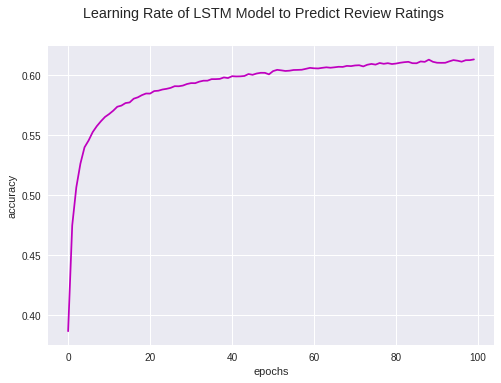

In [0]:
fig = plt.figure()
plt.plot(h.history['acc'], 'm-')
fig.suptitle('Learning Rate of LSTM Model to Predict Review Ratings')
plt.xlabel('epochs')
plt.ylabel('accuracy')
fig.savefig('/content/gdrive/My Drive/learning_curve.jpg')